In [1]:
import sys
import os
from tensorflow.keras.models import load_model
import joblib
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_repo_age_days_col, add_days_since_last_release_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target, scale_final_data, remove_outliers, reduce_dimentionality_pca, forecast_growth, get_single_repo_data, remove_unwanted_features
import numpy as np


/opt/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
test_df = get_single_repo_data('https://github.com/Significant-Gravitas/AutoGPT')

test_df

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,autogpt-v0.5.1,2024-04-26T20:15:57Z,21,158,4271,166742,44110,166742
1,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,autogpt-v0.5.0,2023-12-14T15:17:16Z,21,158,4271,166742,44110,166742
2,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,agbenchmark-v0.0.10,2023-09-17T00:02:08Z,21,158,4271,166742,44110,166742
3,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,v0.4.7,2023-08-11T17:55:06Z,21,158,4271,166742,44110,166742
4,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,v0.4.6,2023-07-28T12:42:29Z,21,158,4271,166742,44110,166742
5,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,v0.4.5,2023-07-19T18:18:47Z,21,158,4271,166742,44110,166742
6,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,v0.4.4,2023-07-11T22:01:35Z,21,158,4271,166742,44110,166742
7,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,v0.4.3,2023-06-28T08:16:40Z,21,158,4271,166742,44110,166742
8,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,v0.4.3-alpha,2023-06-27T10:03:51Z,21,158,4271,166742,44110,166742
9,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-22T02:43:10Z,v0.4.2,2023-06-19T20:45:18Z,21,158,4271,166742,44110,166742


In [4]:
def distribute_values_across_releases(release_dates, total_value):
    """
    Distribute the total value across release dates in an increasing manner.
    """
    n_releases = len(release_dates)
    step = (total_value - n_releases) / (n_releases - 1) if n_releases > 1 else total_value

    values = [1 + round(step * i) for i in range(n_releases)]
    values[-1] = total_value  # Ensure the last value matches the total count
    return values

In [5]:
df_exploded = test_df 

for repo_index, repo_group in df_exploded.groupby(['org_name', 'repo_name']):
    # Get release dates for the current repository
    release_dates = repo_group['release_date']
    
    # Distribute each column across the release dates
    df_exploded.loc[release_dates.index, 'num_stars'] = distribute_values_across_releases(release_dates, repo_group['num_stars'].iloc[0])
    df_exploded.loc[release_dates.index, 'num_forks'] = distribute_values_across_releases(release_dates, repo_group['num_forks'].iloc[0])
    df_exploded.loc[release_dates.index, 'num_watchers'] = distribute_values_across_releases(release_dates, repo_group['num_watchers'].iloc[0])
    df_exploded.loc[release_dates.index, 'num_pull_requests'] = distribute_values_across_releases(release_dates, repo_group['num_pull_requests'].iloc[0])
    df_exploded.loc[release_dates.index, 'num_open_issues'] = distribute_values_across_releases(release_dates, repo_group['num_open_issues'].iloc[0])
    df_exploded.loc[release_dates.index, 'num_releases'] = distribute_values_across_releases(release_dates, repo_group['num_releases'].iloc[0])

In [7]:
test_df = df_exploded

In [8]:
test_df = add_growth_score_based_on_main_features(test_df, train=False)
actual_growth_score = test_df['growth_score']
test_df = add_repo_age_days_col(test_df)

test_df = add_days_since_last_release_col(test_df)
test_df = convert_topics_to_embeddings(test_df)
test_df = remove_outliers(test_df)
test_df = indexify_release_dates(test_df)

test_df = add_lag_features_based_on_target(test_df)

X = remove_unwanted_features(test_df)
test_df_scaled = scale_final_data(X=X.values)
test_df_scaled = reduce_dimentionality_pca(test_df_scaled)

n_features = test_df_scaled.shape[1] 
n_timesteps = 4


test_generator = TimeseriesGenerator(test_df_scaled, np.zeros(len(test_df_scaled)), length=n_timesteps, batch_size=1)
model = load_model('../models/best_rnn_model.keras')
y_pred = model.predict(test_generator)
print(f'predicted: {y_pred[0][0]}', f' | actual: {actual_growth_score[1]}')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/models/growth_score_training_scaler.pkl'

In [ ]:
n_forecast_steps = 12 
scaler_y = joblib.load('../models/final_target_scaler.pkl')

# Perform the forecasting
forecasted_values = forecasted_growth_scores = forecast_growth(
    model=model, 
    initial_data=test_df_scaled, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=5,
    n_features=n_features
)

print("Forecasted Growth Scores:", forecasted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecasted Growth Scores: [1.3912832  0.83918834 1.0356257  1.1871108  1.2448294  0.5584133
 0.56072444 0.5605239  0.5603348  0.5605544  0.56134546 0.5613426 ]


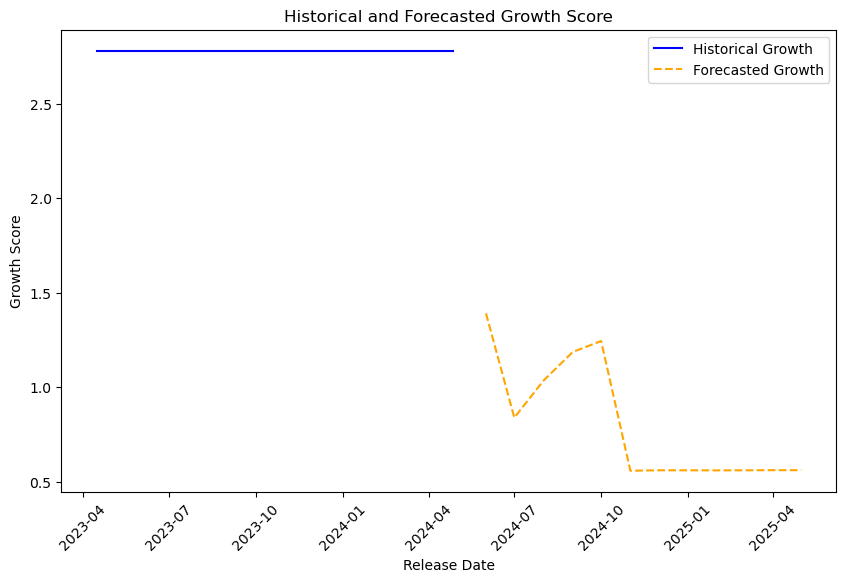

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the index is in datetime format (if not already)
test_df.index = pd.to_datetime(test_df.index)

# Historical data: Plot the actual release dates with the growth score
historical_growth = test_df['growth_score']

# Generate future dates for the forecasted values based on the release_date index
# If you are forecasting 'n_steps' into the future (assuming monthly intervals)
forecasted_dates = pd.date_range(start=test_df.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]

# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, historical_growth, label='Historical Growth', color='blue')

# Plot forecasted data: Aligning the forecasted growth with future dates
plt.plot(forecasted_dates, forecasted_values, label='Forecasted Growth', color='orange', linestyle='--')

# Add labels and title
plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Historical and Forecasted Growth Score')

# Add legend for clarity
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()